# Лабораторная работа №2

Задания:
1. Провести классификацию найденного датасета, методом машины опорных векторов. В формате Markdown писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.

<table>
<tr><th>Название столбца</th><th>Описание</th></tr>
<tr><td>ID</td><td>ID каждого клиента</td></tr>
<tr><td>LIMIT_BAL</td><td>Сумма выданного кредита в долларах NT (включает индивидуальный и семейный/дополнительный кредит)</td></tr>
<tr><td>SEX</td><td>Пол (1=мужской, 2=женский)</td></tr>
<tr><td>EDUCATION</td><td>(1=аспирантура, 2=университет, 3=средняя школа, 4=другое, 5=неизвестно, 6=неизвестно)</td></tr>
<tr><td>MARRIAGE</td><td>Семейное положение (1=замужем, 2=не замужем, 3=другое)</td></tr>
<tr><td>AGE</td><td>Возраст в годах</td></tr>
<tr><td>PAY_0</td><td>Статус погашения в сентябре 2005 года (-2=нет потребления, -1=оплачиваю должным образом, 0=использование возобновляемого кредита, 1=задержка платежа на один месяц, 2=задержка платежа на два месяца, ... )</td></tr>
<tr><td>PAY_2</td><td>Статус погашения в августе 2005 года (шкала такая же, как и выше)</td></tr>
<tr><td>PAY_3</td><td>Статус погашения в июле 2005 года (шкала та же, что и выше)</td></tr>
<tr><td>PAY_4</td><td>Статус погашения в июне 2005 года (шкала такая же, как выше)</td></tr>
<tr><td>PAY_5</td><td>Статус погашения в мае, 2005 (шкала такая же, как выше)</td></tr>
<tr><td>PAY_6</td><td>Статус погашения в апреле 2005 года (шкала такая же, как выше)</td></tr>
<tr><td>BILL_AMT1</td><td>Сумма выписки счета в сентябре, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT2</td><td>Сумма выписки по счету за август, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT3</td><td>Сумма выписки счета за июль, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT4</td><td>Сумма выписки счета за июнь, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT5</td><td>Сумма выписки счета за май, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT6</td><td>Сумма выписки счета за апрель, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT1 </td><td>Сумма предыдущего платежа в сентябре, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT2 </td><td>Сумма предыдущего платежа в августе, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT3 </td><td>Сумма предыдущего платежа в июле, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT4</td><td>Сумма предыдущего платежа в июне, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT5</td><td>Сумма предыдущего платежа в мае, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT6</td><td>Сумма предыдущего платежа в апреле, 2005 (NT доллар)</td></tr>
<tr><td>default payment next montr </td><td>Платеж по умолчанию (1=да, 0=нет)</td></tr>
</table>

In [2]:
import pandas
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plot
data = pandas.read_csv("data.csv", sep=',', index_col='ID');

## Обработка данных
- Пол, семейное положение и возраст - категорийные признаки.
- Значения EDUCATION 0,4,5,6 имеют одинаковый смысл.
- Значения MARRIAGE 0,3 имеют одинаковый смысл.

In [3]:
data[['SEX','MARRIAGE','EDUCATION']] = data[['SEX','MARRIAGE','EDUCATION']].astype('object')
data.loc[data["MARRIAGE"]==3, "MARRIAGE"] = 0
data.loc[data["EDUCATION"] > 3, "EDUCATION"] = 0

## Разметка данных

Сокращаем число записей и перемешиваем их.

In [4]:
def_data = data[data['default payment next month']==0]
ndef_data = data[data['default payment next month']==1]
res_data = pandas.concat([resample(def_data, replace=False, n_samples=1000, random_state=42),
                          resample(ndef_data, replace=False, n_samples=1000, random_state=42)])
X = res_data.drop("default payment next month", axis=1, inplace=False)
Y = res_data["default payment next month"]
X_full = data.drop("default payment next month", axis=1, inplace=False)
Y_full = data["default payment next month"]
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y,)
train_X_full, test_X_full, train_Y_full, test_Y_full = train_test_split(X_full, Y_full, stratify=Y_full,)
params = {
    "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
}

## Поиск наилучших параметров

Полный поиск по заданным значениям параметров для получения оценки.
Параметры оптимизируются путем перекрестной проверки по сетке параметров.

In [11]:
params = [
    {'C': range(1,100), # NOTE: Values for C must be > 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}, # we can try other kernel settings but its time consuming. Radial Basis Function usually has best performance
]

grid_search = GridSearchCV(
    SVC(),    
    params, # above parameters
    cv=5, # folds to Cross Validate
    n_jobs=16
)

grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

{'C': 72, 'gamma': 'scale', 'kernel': 'rbf'}


## Классификация

In [5]:
svm_classifier = SVC (C=72, gamma="scale",probability=True) 
svm_classifier.fit(train_X_full, train_Y_full)
test_predict_Y = svm_classifier.predict(test_X_full)  
test_predict_proba_Y = svm_classifier.predict_proba(test_X_full)[:,1]      

## Статистика по результатам

Точность на тестовой выборке: 0.7768


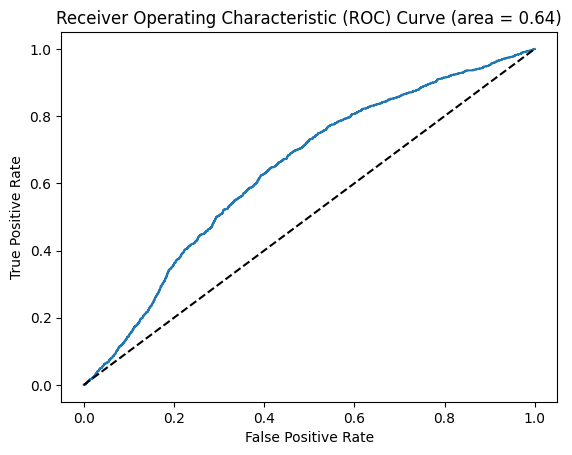

Classification Report of Test
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      5841
           1       0.14      0.00      0.00      1659

    accuracy                           0.78      7500
   macro avg       0.46      0.50      0.44      7500
weighted avg       0.64      0.78      0.68      7500



In [6]:
print('Точность на тестовой выборке:',accuracy_score(test_Y_full,test_predict_Y))
# Вычисление ROC-кривой и её параметров
fpr, tpr, thresholds = roc_curve(test_Y_full, test_predict_proba_Y)

# Построение ROC-кривой
plot.plot(fpr, tpr)
plot.plot([0, 1], [0, 1], 'k--')  # Случайное предсказание
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve (area = %0.2f)'% roc_auc_score(test_Y_full, test_predict_proba_Y))
plot.show()

print('Classification Report of Test\n',  classification_report(test_Y_full, test_predict_Y))